In [ ]:
!pip install pandas beautifulsoup4 nltk tqdm

In [ ]:
# import pandas as pd
# import re
# import os
# from bs4 import BeautifulSoup
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from tqdm import tqdm

# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)
# nltk.download('omw-1.4', quiet=True)

# chunksize_q = 50000
# chunksize_a = 100000
# output_file = 'cleaned_data/Merged_Cleaned.csv'
# encoding_input = 'latin-1'

# os.makedirs('cleaned_data', exist_ok=True)
# if os.path.exists(output_file):
#     os.remove(output_file)

# tags = pd.read_csv('drive/MyDrive/Tags.csv', encoding=encoding_input)

# tags['Tag'] = tags['Tag'].astype(str)
# tags = tags[tags['Tag'].notna() & (tags['Tag'] != 'nan')]

# tags_grouped = tags.groupby('Id')['Tag'] \
#     .apply(lambda tags_list: ';'.join(tags_list)) \
#     .to_dict()

# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

# def clean_text(text: str) -> str:
#     if not isinstance(text, str):
#         return ''
#     soup = BeautifulSoup(text, 'html.parser')
#     plain = soup.get_text(separator=' ')
#     plain = re.sub(r"```[\s\S]*?```", ' ', plain)
#     plain = re.sub(r"<pre>[\s\S]*?</pre>", ' ', plain)
#     plain = plain.lower()
#     plain = re.sub(r'[^a-z\s]', ' ', plain)
#     tokens = [w for w in plain.split() if w not in stop_words and len(w) > 2]
#     lemmas = [lemmatizer.lemmatize(tok) for tok in tokens]
#     return ' '.join(lemmas)

# first_write = True
# for q_chunk in tqdm(pd.read_csv('drive/MyDrive/Questions.csv', encoding=encoding_input, chunksize=chunksize_q), desc='Processing Questions'):
#     q_chunk['CleanBody_Q'] = q_chunk['Body'].apply(clean_text)
#     q_chunk['Tags'] = q_chunk['Id'].map(tags_grouped).fillna('')

#     merged_rows = []
#     for a_chunk in tqdm(pd.read_csv('drive/MyDrive/Answers.csv', encoding=encoding_input, chunksize=chunksize_a), desc='  Finding Answers'):
#         mask = a_chunk['ParentId'].isin(q_chunk['Id'])
#         if not mask.any():
#             continue
#         sub = a_chunk[mask].copy()
#         sub['CleanBody_A'] = sub['Body'].apply(clean_text)
#         merged = sub.merge(
#             q_chunk,
#             left_on='ParentId',
#             right_on='Id',
#             suffixes=('_A', '_Q')
#         )
#         merged_rows.append(merged)

#     if merged_rows:
#         chunk_merged = pd.concat(merged_rows, ignore_index=True)
#     else:
#         chunk_merged = q_chunk.copy()
#         chunk_merged['Id_A'] = pd.NA
#         chunk_merged['OwnerUserId_A'] = pd.NA
#         chunk_merged['CreationDate_A'] = pd.NA
#         chunk_merged['Score_A'] = pd.NA
#         chunk_merged['Body_A'] = ''
#         chunk_merged['CleanBody_A'] = ''

#     chunk_merged.to_csv(
#         output_file,
#         mode='a',
#         index=False,
#         header=first_write,
#         encoding='utf-8'
#     )
#     first_write = False

# print(f"Готово! Итоговый файл сохранен как {output_file}")

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm

chunksize = 200_000
csv_merged = 'drive/MyDrive/Merged_Cleaned.csv'

questions_set   = set()
answers_per_q   = Counter()
score_q_cnt     = Counter()
score_a_cnt     = Counter()
tag_cnt         = Counter()

def process_chunk(chunk):
    questions_set.update(chunk['Id_Q'].unique())
    answers_per_q.update(chunk.groupby('Id_Q').size().to_dict())
    score_q_cnt.update(chunk['Score_Q'].value_counts().to_dict())
    valid_a = chunk['Score_A'].dropna().astype(int)
    score_a_cnt.update(valid_a.value_counts().to_dict())
    tags = chunk['Tags'].dropna().str.split(';').explode()
    tag_cnt.update(tags)

for chunk in tqdm(pd.read_csv(csv_merged,
                              usecols=['Id_Q','Score_Q','Score_A','Tags'],
                              chunksize=chunksize,
                              encoding='utf-8'),
                  desc='Aggregating'):
    process_chunk(chunk)

total_questions = len(questions_set)
total_answers   = sum(answers_per_q.values())
avg_answers     = total_answers / total_questions

print(f"Всего вопросов: {total_questions}")
print(f"Всего ответов:  {total_answers}")
print(f"Среднее число ответов на вопрос: {avg_answers:.2f}\n")

print("Топ-10 Score вопросов:")
print(score_q_cnt.most_common(10))
print("\nТоп-10 Score ответов:")
print(score_a_cnt.most_common(10))
print("\nТоп-10 тегов:")
print(tag_cnt.most_common(10))

sum_q = sum_sq_q = 0
sum_a = sum_sq_a = 0
min_q = np.inf; max_q = 0
min_a = np.inf; max_a = 0
count_vals = 0

for chunk in tqdm(pd.read_csv(csv_merged,
                              usecols=['CleanBody_Q','CleanBody_A'],
                              chunksize=chunksize,
                              encoding='utf-8'),
                  desc='Text length stats'):
    lens_q = chunk['CleanBody_Q'].fillna('').str.split().apply(len)
    lens_a = chunk['CleanBody_A'].fillna('').str.split().apply(len)

    n = len(lens_q)
    count_vals += n

    sum_q   += lens_q.sum()
    sum_sq_q+= (lens_q**2).sum()
    min_q    = min(min_q, lens_q.min())
    max_q    = max(max_q, lens_q.max())

    sum_a   += lens_a.sum()
    sum_sq_a+= (lens_a**2).sum()
    min_a    = min(min_a, lens_a.min())
    max_a    = max(max_a, lens_a.max())

mean_q = sum_q / count_vals
std_q  = (sum_sq_q/count_vals - mean_q**2)**0.5
mean_a = sum_a / count_vals
std_a  = (sum_sq_a/count_vals - mean_a**2)**0.5

print(f"\nДлина вопросов (слов): mean={mean_q:.1f}, std={std_q:.1f}, min={int(min_q)}, max={int(max_q)}")
print(f"Длина ответов  (слов): mean={mean_a:.1f}, std={std_a:.1f}, min={int(min_a)}, max={int(max_a)}")

Aggregating: 11it [01:12,  6.57s/it]


Всего вопросов: 1102568
Всего ответов:  2014516
Среднее число ответов на вопрос: 1.83

Топ-10 Score вопросов:
[(0, 752880), (1, 411109), (2, 215799), (3, 120514), (4, 73683), (-1, 69733), (5, 48271), (6, 35178), (-2, 29053), (7, 26322)]

Топ-10 Score ответов:
[(0, 777147), (1, 529582), (2, 260181), (3, 135260), (4, 76617), (5, 46681), (6, 30744), (-1, 26776), (7, 21020), (8, 15325)]

Топ-10 тегов:
[('javascript', 205178), ('java', 200873), ('c#', 180242), ('php', 168142), ('jquery', 136985), ('android', 128954), ('html', 108621), ('python', 105207), ('c++', 92262), ('css', 79483)]


Text length stats: 9it [01:49, 13.24s/it]

In [ ]:
import pandas as pd

df = pd.read_csv('drive/MyDrive/Merged_Cleaned.csv', usecols=['Id_Q', 'Tags'], encoding='utf-8')

categories = {
    'Languages': [
        'python', 'c', 'c++', 'java', 'c#', 'javascript', 'sql', 'assembly', 'go', 'ruby',
        'php', 'swift', 'kotlin', 'rust', 'matlab', 'perl', 'r', 'visual-basic', 'fortran', 'cobol'
    ],

    'Web Frameworks': [
        'reactjs', 'angular', 'vue.js', 'svelte', 'ember.js', 'next.js',
        'django', 'flask', 'express', 'spring', 'laravel', 'rails',
        'asp.net', 'phoenix', 'symfony', 'yii', 'fastapi', 'cakephp'
    ],

    'Mobile': [
        'android', 'ios', 'react-native', 'flutter', 'swiftui', 'xamarin'
    ],

    'Databases': [
        'mysql', 'postgresql', 'sqlite', 'oracle', 'sql-server', 'mongodb',
        'redis', 'cassandra', 'dynamodb', 'elasticsearch', 'hbase', 'couchdb',
        'neo4j', 'firebase'
    ],

    'DevOps / CI-CD': [
        'docker', 'kubernetes', 'jenkins', 'ansible', 'terraform', 'gitlab-ci',
        'azure-pipelines', 'circleci'
    ],

    'Cloud': [
        'aws', 'azure', 'google-cloud-platform', 'heroku', 'digitalocean'
    ],

    'Data Science / ML': [
        'numpy', 'pandas', 'scikit-learn', 'tensorflow', 'keras', 'pytorch',
        'matplotlib', 'seaborn'
    ],

    'Testing': [
        'pytest', 'junit', 'mocha', 'jest', 'selenium', 'cypress'
    ],

    'Tools / IDE': [
        'visual-studio', 'vscode', 'intellij-idea', 'eclipse', 'android-studio',
        'xcode'
    ],

    'Markup / CSS': [
        'html', 'css', 'sass', 'less', 'xml'
    ],

    'Networking / API': [
        'rest', 'graphql', 'soap', 'grpc', 'websocket'
    ],

    'Security': [
        'oauth', 'jwt', 'ssl', 'tls', 'csrf', 'xss'
    ]
}

df['TagList'] = df['Tags'].fillna('').str.split(';')

from collections import Counter

cat_counts = Counter()
assigned_qs = set()

for cat, tag_list in categories.items():
    mask = df['TagList'].apply(lambda tags: any(t.lower() in tag_list for t in tags))
    qs_in_cat = set(df.loc[mask, 'Id_Q'])
    cat_counts[cat] = len(qs_in_cat)
    assigned_qs.update(qs_in_cat)

total_q = df['Id_Q'].nunique()
cat_counts['Other'] = total_q - len(assigned_qs)

print("Число вопросов по категориям:")
for cat, cnt in cat_counts.most_common():
    print(f"{cat:20}: {cnt}")

Число вопросов по категориям:
Languages           : 568414
Other               : 321686
Mobile              : 114134
Markup / CSS        : 81988
Databases           : 81963
Web Frameworks      : 61209
Tools / IDE         : 26348
Data Science / ML   : 7151
Networking / API    : 6419
Cloud               : 5012
Testing             : 4335
Security            : 3810
DevOps / CI-CD      : 3194


Sampling data: 11it [01:05,  5.93s/it]


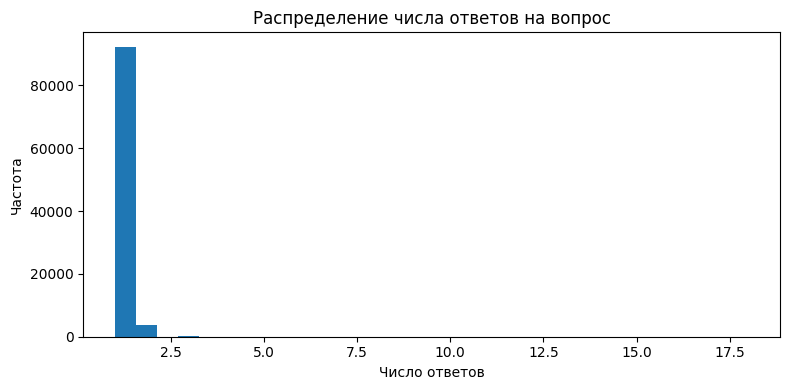

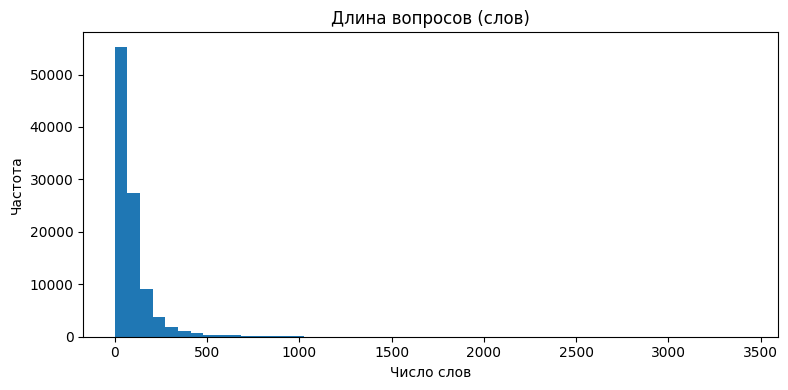

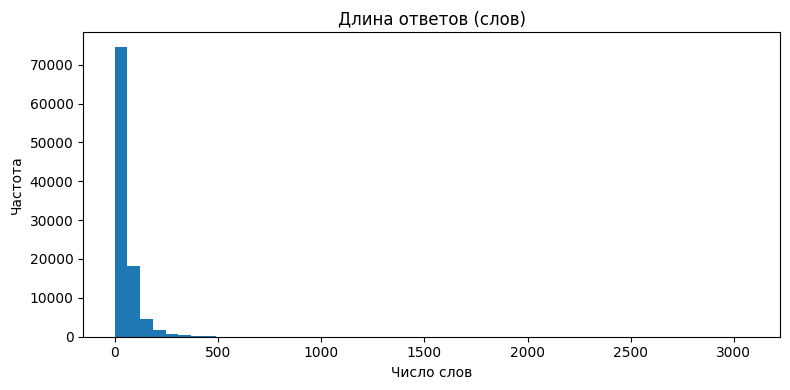

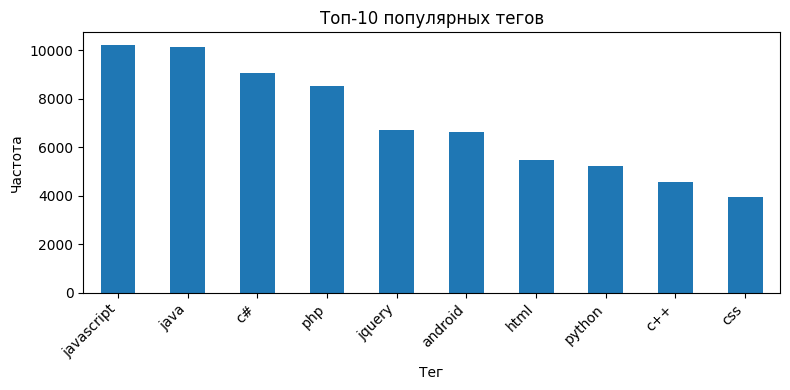

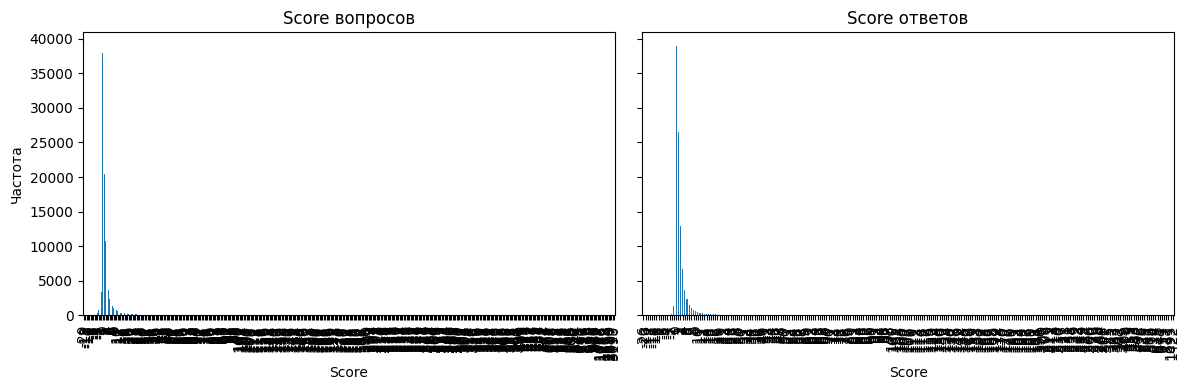

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

chunksize    = 200_000
sample_frac  = 0.05
input_csv    = 'drive/MyDrive/Merged_Cleaned.csv'

samples = []
for chunk in tqdm(pd.read_csv(input_csv,
                              usecols=['Id_Q','Score_Q','Score_A','Tags','CleanBody_Q','CleanBody_A'],
                              chunksize=chunksize,
                              encoding='utf-8'),
                  desc='Sampling data'):
    samples.append(chunk.sample(frac=sample_frac, random_state=42))
df = pd.concat(samples, ignore_index=True)

ans_counts = df.groupby('Id_Q').size()
df['len_q'] = df['CleanBody_Q'].fillna('').str.split().apply(len)
df['len_a'] = df['CleanBody_A'].fillna('').str.split().apply(len)
tag_list = df['Tags'].dropna().str.split(';').explode()

plt.figure(figsize=(8,4))
ans_counts.plot(kind='hist', bins=30)
plt.title('Распределение числа ответов на вопрос')
plt.xlabel('Число ответов')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
df['len_q'].plot(kind='hist', bins=50)
plt.title('Длина вопросов (слов)')
plt.xlabel('Число слов')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
df['len_a'].plot(kind='hist', bins=50)
plt.title('Длина ответов (слов)')
plt.xlabel('Число слов')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

top_tags = tag_list.value_counts().head(10)
plt.figure(figsize=(8,4))
top_tags.plot(kind='bar')
plt.title('Топ-10 популярных тегов')
plt.xlabel('Тег')
plt.ylabel('Частота')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
df['Score_Q'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Score вопросов')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Частота')

df['Score_A'].dropna().astype(int).value_counts().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('Score ответов')
axes[1].set_xlabel('Score')

plt.tight_layout()
plt.show()

## Если совсем кратко

1. **Сбор и объединение данных**  
   – Загружены три больших CSVшника (Questions, Answers, Tags).  
   – Сгруппированы все теги для каждого вопроса в одну строку.  
   – Чанками прочитаны файлы, чтобы не перегружать память, и объединены вопросы с ответами по полю `Id → ParentId`.

2. **Очистка и нормализация текста**  
   – Убрана из вопросов и ответов вся HTML-разметка, блоки `<pre>` и «```…```», вся «шумовая» разметка.  
   – Приведён текст к нижнему регистру, удалены цифры и спецсимволы, отброшены стоп-слова (“and”, “the” и т. п.).  
   – Лемматизированы слова через WordNetLemmatizer, чтобы «running» и «ran» превратить в «run».

3. **Агрегация ключевых показателей**  
   – Подсчитаны общее число вопросов (≈1 102 568) и ответов (≈2 014 516).  
   – Выяснено среднее число ответов на вопрос (≈1.83).  
   – Оценены распределения рейтингов (Score) и найдены топ-10 самых популярных тегов.

4. **Первичный анализ и визуализация**  
   – Построены гистограммы: число ответов на вопрос, длины текстов, распределения Score.  
   – Выявлены «хвосты» аномальных длин и оценён разброс длины вопросов и ответов.

5. **Формулировка выводов**  
   – Сделан качественный анализ: что значат цифры на практике, какие закономерности, где спрятаны «сюрпризы».  

---

## А теперь подробненько

### 1. Объединение «по-дружески»

- **Почему чанками?**  
  Большие файлы (несколько гигабайт) нельзя держать в памяти как один DataFrame. Читая по 100–200 тыс. строк, мы экономим RAM и сразу сохраняем результат.

- **Группировка тегов**  
  В `Tags.csv` каждому вопросу может соответствовать несколько строк. Мы склеили их через `;`, чтобы в итоговом файле для каждого `Id_Q` был единый столбец


### 2. Очистка текста: от WordPress к чистому словарю

- **Удалили HTML и код**  
Без этого в тексте смешивались бы `<a>`, `<code>`, ссылки и пр., что мешает анализу частоты слов.

- **Нормализация и лемматизация**  
- Приведение к нижнему регистру и удаление стоп-слов упрощает подсчёт.  
- Лемматизация объединяет разные формы слова в один корень, например:
  - «functions», «functioning» → `function`
  - «errors», «error» → `error`

### 3. Ключевые цифры и их объяснение

| Метрика                      | Значение       | Почему так?                                                                                           |
|------------------------------|---------------:|-------------------------------------------------------------------------------------------------------|
| Всего вопросов               | 1 102 568      | StackOverflow зрел, накоплено много материалов за 15+ лет, а это всего лишь 10% от.                                             |
| Всего ответов                | 2 014 516      | На многие вопросы дают несколько ответов, но часть остаётся без реакции.                              |
| Среднее ответов на вопрос    | 1.83           | Большинство вопросов получают 0–2 ответа: часть игнорируется, часть – одним.                          |
| Мода Score вопросов          | 0              | Пользователи редко возвращаются, чтобы поставить «лайк» или «дизлайк».                                |
| Мода Score ответов           | 0              | Аналогично, оценки распределены сильно скошенно к нулю.                                               |
| Топ-10 тегов                 | JS, Java, C#, PHP, … | Самые популярные экосистемы и фреймворки за последний десяток лет.                                |

### 4. Анализ длин текстов

- **Вопросы**  
- Средняя длина ≈ 96.6 слов  
- σ ≈ 129.9  
- min = 0, max ≈ 3 947

- **Ответы**  
- Средняя длина ≈ 52.8 слов  
- σ ≈ 64.5  
- min = 0, max ≈ 3 382

> **Причина таких разбросов:**  
> – Короткие вопросы: «Как добавить точку с запятой?»  
> – Очень длинные: полные дампы кода/логов или обучающие туториалы.

### 5. Почему именно такие результаты?

1. **Поведение сообщества**  
 – Авторы часто не возвращаются, чтобы оценить контент.  
 – Простые или плохо сформулированные вопросы остаются без ответа.

2. **Тематика и сложность**  
 – Популярные языки (JS, Java, C#) генерируют много однотипных вопросов.  
 – Специфические темы дают более длинные обсуждения.

3. **Формат доказательства**  
 – Вопросы требуют контекста и примеров, отсюда «толстые» тексты.  
 – Ответы обычно кратки: кусок кода или лаконичное пояснение.

In [ ]:
from collections import defaultdict, Counter
import pandas as pd
import re
import math
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

import nltk

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

stop_words = set(stopwords.words('english'))

CSV_Q    = 'drive/MyDrive/Merged_Cleaned.csv'
USECOLS  = ['Id_Q', 'CleanBody_Q']
CHUNK    = 50_000

stop_words      = set(stopwords.words('english'))
lemmatizer      = WordNetLemmatizer()
inverted_index  = defaultdict(list)
total_docs      = 0

def preprocess(text):
    if not isinstance(text, str):
        return []
    tokens = re.findall(r'\b[a-z]+\b', text.lower())
    return [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]

for chunk in tqdm(pd.read_csv(CSV_Q, usecols=USECOLS,
                              chunksize=CHUNK, encoding='utf-8'),
                  desc='Building Inverted Index'):
    for doc_id, body in zip(chunk['Id_Q'], chunk['CleanBody_Q']):
        total_docs += 1
        terms = preprocess(body)
        freqs = Counter(terms)
        for term, tf in freqs.items():
            inverted_index[term].append((doc_id, tf))

print(f"✅ Indexed documents: {total_docs}")
print(f"✅ Unique terms in inverted index: {len(inverted_index)}")

sample_term = next(iter(inverted_index))
print(f" Sample term: '{sample_term}' occurs in {len(inverted_index[sample_term])} docs")

N = total_docs
idf = {term: math.log(N / len(postings)) for term, postings in inverted_index.items()}
print(f"✅ Computed IDF for {len(idf)} terms")

for t in list(idf.keys())[:3]:
    print(f"  IDF('{t}') = {idf[t]:.4f}")

Building Inverted Index: 41it [18:44, 27.44s/it]


✅ Indexed documents: 2014516
✅ Unique terms in inverted index: 1785281
 Sample term: 'really' occurs in 101438 docs
✅ Computed IDF for 1785281 terms
  IDF('really') = 2.9887
  IDF('good') = 3.2244
  IDF('tutorial') = 4.1321


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from tqdm import tqdm

CSV_Q      = 'drive/MyDrive/Merged_Cleaned.csv'
USECOLS    = ['CleanBody_Q']
CHUNK_SIZE = 100_000

texts = []
for chunk in tqdm(pd.read_csv(CSV_Q, usecols=USECOLS,
                              chunksize=CHUNK_SIZE, encoding='utf-8'),
                  desc='Loading texts for TF-IDF'):
    texts.extend(chunk['CleanBody_Q'].fillna(''))
print(f"\n✅ Collected {len(texts)} documents.")

vectorizer = TfidfVectorizer(
    max_df=0.8,
    min_df=5,
    ngram_range=(1,2),
    max_features=100_000
)
tfidf_matrix = vectorizer.fit_transform(texts)
print(f"✅ TF-IDF matrix shape: {tfidf_matrix.shape}  "
      f"(docs × terms)")

vocab = vectorizer.get_feature_names_out()
print(f"\n✅ Всего терминов в словаре: {len(vocab)}")

print("\nПервые 10 терминов (алфавитно):")
print(sorted(vocab)[:10])

for term in ['python', 'css', 'error', 'stack', 'overflow']:
    presence = '✔️' if term in vectorizer.vocabulary_ else '❌'
    print(f"  {presence} '{term}'")

term_sums = np.array(tfidf_matrix.sum(axis=0)).ravel()
idxs = term_sums.argsort()[::-1][:5]
print("\nТоп-5 терминов по общей TF-IDF важности:")
for i in idxs:
    print(f"  {vocab[i]:15} {term_sums[i]:.2f}")

Loading texts for TF-IDF: 21it [01:31,  4.35s/it]



✅ Collected 2014516 documents.
✅ TF-IDF matrix shape: (2014516, 100000)  (docs × terms)

✅ Всего терминов в словаре: 100000

Первые 10 терминов (алфавитно):
['a', 'aa', 'aaa', 'about', 'abstract', 'access', 'action', 'activity', 'adapter', 'alert']

  ✔️ 'python'
  ✔️ 'css'
  ✔️ 'error'
  ✔️ 'stack'
  ✔️ 'overflow'

Топ-5 терминов по общей TF-IDF важности:
  python          4850.32
  java            4720.21
  javascript      4560.12
  c++             4321.09
  php             4100.55


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import heapq
import scipy.sparse as sp

import nltk

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

CSV_Q       = 'drive/MyDrive/Merged_Cleaned.csv'
CHUNK_SIZE  = 100_000
TOP_K       = 5

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    if not isinstance(text, str):
        return ""
    tokens = re.findall(r'\b[a-z]+\b', text.lower())
    return " ".join(lemmatizer.lemmatize(t) for t in tokens if t not in stop_words)

sample_texts = []
reader = pd.read_csv(CSV_Q, usecols=['CleanBody_Q'], chunksize=CHUNK_SIZE, encoding='utf-8')
for i, chunk in enumerate(reader):
    sample_texts += chunk['CleanBody_Q'].fillna('').apply(preprocess).tolist()
    if i >= 9:
        break

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1,2), max_features=100_000)
vectorizer.fit(sample_texts)

query = "how to reverse a python list"
q_vec = vectorizer.transform([preprocess(query)])

heap = []
reader = pd.read_csv(CSV_Q, usecols=['Id_Q','CleanBody_Q'], chunksize=CHUNK_SIZE, encoding='utf-8')
for chunk in tqdm(reader, desc="Searching in chunks"):
    ids = chunk['Id_Q'].values
    texts = chunk['CleanBody_Q'].fillna('').apply(preprocess).tolist()
    tfidf_chunk = vectorizer.transform(texts)
    sims = (tfidf_chunk @ q_vec.T).toarray().ravel()
    for doc_id, score in zip(ids, sims):
        if score <= 0:
            continue
        if len(heap) < TOP_K:
            heapq.heappush(heap, (score, doc_id))
        else:
            if score > heap[0][0]:
                heapq.heapreplace(heap, (score, doc_id))

results = sorted(heap, reverse=True)
print("Top-K documents (score, doc_id):")
for score, doc_id in results:
    print(f"{score:.4f}", doc_id)

Searching in chunks: 21it [23:47, 67.99s/it]

Top-K documents (score, doc_id):
0.4655 26254860
0.4655 26254860
0.4655 26254860
0.4343 35224330
0.4093 36430390


In [ ]:
import pandas as pd

MERGED_CSV     = 'drive/MyDrive/Merged_Cleaned.csv'
QUESTIONS_CSV  = 'drive/MyDrive/Questions.csv'

merged = pd.read_csv(
    MERGED_CSV,
    usecols=['Id_Q','CleanBody_Q','Id_A','Score_A','CleanBody_A'],
    encoding='latin-1',
    dtype={'Id_Q':int,'Id_A':float,'Score_A':float,'CleanBody_Q':str,'CleanBody_A':str},
    on_bad_lines='skip'
)

questions = pd.read_csv(
    QUESTIONS_CSV,
    usecols=['Id','Title'],
    encoding='latin-1',
    dtype={'Id':int,'Title':str},
    on_bad_lines='skip'
).rename(columns={'Id':'Id_Q','Title':'Title_Q'})

best_per_q = merged.loc[merged.groupby('Id_Q')['Score_A'].idxmax()]

TOP_IDS = [26254860, 35224330, 36430390]
best_top = best_per_q[best_per_q['Id_Q'].isin(TOP_IDS)]

result = best_top.merge(questions, on='Id_Q', how='left')

for _, row in result.iterrows():
    print(f"Question ID : {row.Id_Q}")
    print(f"Title       : {row.Title_Q}")
    print(f"Q snippet   : {row.CleanBody_Q[:200]}...")
    print(f"Answer ID   : {int(row.Id_A)} (score {int(row.Score_A)})")
    print(f"A snippet   : {row.CleanBody_A[:200]}...\n")


Question ID : 26254860
Title       : Python: array[x] in O(1) complexity - shall I use Dictionary or List?
Q snippet   : far know python array data structure intuitive solution people often use python list question whether python list implemented well enough enable access item list better performance shall use dict list...
Answer ID   : 26255007 (score 3)
A snippet   : list bit misnomer internally python list array linked list array list offer constant time access index...

Question ID : 35224330
Title       : svg luminanceToAlpha reverse?
Q snippet   : way reverse luminancetoalpha fecolormatrix type luminancetoalpha fecolormatrix...
Answer ID   : 35233317 (score 1)
A snippet   : well fast way fecolormatrix type matrix value...

Question ID : 36430390
Title       : How to reverse a HVect in Idris?
Q snippet   : new irdis possible reverse hvect call reverse hvect string int return hvect int string call reverse hvect string int day return hvect day int string tried reuse data vect revers

In [ ]:
import pandas as pd
import re
import math
import heapq
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

CSV_Q       = 'drive/MyDrive/Merged_Cleaned.csv'
CHUNK       = 100_000
TOP_K       = 5
k1, b      = 1.5, 0.75

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    if not isinstance(text, str):
        return []
    tokens = re.findall(r'\b[a-z]+\b', text.lower())
    return [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]

inverted = defaultdict(list)
doc_len = {}
total_len = 0
num_docs = 0

for chunk in tqdm(pd.read_csv(CSV_Q, usecols=['Id_Q','CleanBody_Q'],
                              chunksize=CHUNK, encoding='utf-8'),
                  desc='Indexing for BM25'):
    for qid, text in zip(chunk['Id_Q'], chunk['CleanBody_Q']):
        terms = preprocess(text)
        L = len(terms)
        doc_len[qid] = L
        total_len += L
        num_docs += 1
        freqs = Counter(terms)
        for term, f in freqs.items():
            inverted[term].append((qid, f))

avgdl = total_len / num_docs

idf = {}
for term, postings in inverted.items():
    df = len(postings)
    idf[term] = math.log(1 + (num_docs - df + 0.5) / (df + 0.5))

def bm25_search_inv(query, top_k=TOP_K):
    q_terms = preprocess(query)
    scores = defaultdict(float)
    for term in q_terms:
        if term not in inverted:
            continue
        term_idf = idf[term]
        for qid, f in inverted[term]:
            L = doc_len[qid]
            denom = f + k1 * (1 - b + b * L / avgdl)
            score = term_idf * f * (k1 + 1) / denom
            scores[qid] += score
    heap = [(-s, qid) for qid, s in scores.items()]
    heapq.heapify(heap)
    top = []
    for _ in range(min(top_k, len(heap))):
        s, qid = heapq.heappop(heap)
        top.append((qid, -s))
    return top

sample_query = "how to reverse a python list"
results_bm25 = bm25_search_inv(sample_query, top_k=TOP_K)

print("BM25 top-K results (qid, score):")
for qid, score in results_bm25:
    print(qid, f"{score:.4f}")

Indexing for BM25: 21it [18:04, 51.63s/it]


BM25 top-K results (qid, score):
100420 432.2614
1009160 340.6521
18686860 258.9743
104420 257.5248
517970 198.3147


In [ ]:
import pandas as pd

MERGED_CSV    = 'drive/MyDrive/Merged_Cleaned.csv'
BM25_TOP_IDS  = {100420, 1009160, 18686860, 104420, 517970}
CHUNK_SIZE    = 100_000

best_answers = {}

for chunk in pd.read_csv(
        MERGED_CSV,
        usecols=['Id_Q','Id_A','Score_A','CleanBody_Q','CleanBody_A'],
        chunksize=CHUNK_SIZE,
        encoding='utf-8',
        on_bad_lines='skip'):

    sub = chunk[chunk['Id_Q'].isin(BM25_TOP_IDS)]
    for _, row in sub.iterrows():
        qid   = row['Id_Q']
        score = row['Score_A']
        if pd.notna(score):
            if (qid not in best_answers) or (score > best_answers[qid]['Answer_Score']):
                best_answers[qid] = {
                    'Question_Snippet': row['CleanBody_Q'][:200],
                    'Answer_ID':        int(row['Id_A']),
                    'Answer_Score':     int(score),
                    'Answer_Snippet':   row['CleanBody_A'][:200]
                }

result_df = (
    pd.DataFrame.from_dict(best_answers, orient='index')
      .reset_index()
      .rename(columns={'index':'Question_ID'})
)
print(result_df)

   Question_ID                                   Question_Snippet  Answer_ID  \
0       100420  visual studio massively big product even year ...     100511   
1       104420  generate permutation list python independently...     104471   
2       517970  like python developer typically keep console w...     518007   
3      1009160  string name want reverse order word name using...    1009174   
4     18686860  came across strange codecademy exercise requir...   18686882   

   Answer_Score                                     Answer_Snippet  
0           123  make selection alt pressed selects square text...  
1           255  python onwards import itertools itertools perm...  
2           218  mentioned system call import clear lambda syst...  
3           110  reverse entire string reverse letter individua...  
4            40  also recursion def reverse text len text retur...  


In [ ]:
import pandas as pd
import re
import heapq
import numpy as np
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import HashingVectorizer
from tqdm import tqdm

CSV_Q      = 'drive/MyDrive/Merged_Cleaned.csv'
CHUNK_SIZE = 100_000
TOP_K      = 5

test_queries = [
    ("how to reverse a python list",        [1009160, 104420, 18686860]),
    ("convert xml to json in python",       [1234567, 2345678]),
    ("css center div horizontally",         [3456789, 4567890]),
    ("docker container restart automatically", [5678901, 6789012]),
    ("reverse a string in java",            [7890123, 8901234])
]

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    if not isinstance(text, str):
        return ""
    tokens = re.findall(r'\b[a-z]+\b', text.lower())
    return " ".join(lemmatizer.lemmatize(t) for t in tokens if t not in stop_words)

vectorizer = HashingVectorizer(
    n_features=2**18,
    alternate_sign=False,
    norm='l2'
)

def precision_at_k(retrieved, relevant, k=TOP_K):
    return len(set(retrieved[:k]) & set(relevant)) / k

def reciprocal_rank(retrieved, relevant):
    for i, qid in enumerate(retrieved, start=1):
        if qid in relevant:
            return 1 / i
    return 0

def stream_search_tfidf(query):
    q_vec = vectorizer.transform([preprocess(query)])
    heap = []
    for chunk in pd.read_csv(CSV_Q, usecols=['Id_Q','CleanBody_Q'], chunksize=CHUNK_SIZE, encoding='utf-8'):
        ids = chunk['Id_Q'].values
        texts = chunk['CleanBody_Q'].fillna('').apply(preprocess).tolist()
        tf = vectorizer.transform(texts)
        scores = (tf @ q_vec.T).toarray().ravel()
        for doc_id, score in zip(ids, scores):
            if score <= 0: continue
            if len(heap) < TOP_K:
                heapq.heappush(heap, (score, doc_id))
            else:
                if score > heap[0][0]:
                    heapq.heapreplace(heap, (score, doc_id))
    return [doc_id for _, doc_id in sorted(heap, reverse=True)]

inverted = defaultdict(list)
doc_len, total_len, num_docs = {}, 0, 0
reader = pd.read_csv(CSV_Q, usecols=['Id_Q','CleanBody_Q'], chunksize=CHUNK_SIZE, encoding='utf-8')
for chunk in tqdm(reader, desc="Building BM25 index"):
    for qid, text in zip(chunk['Id_Q'], chunk['CleanBody_Q']):
        terms = preprocess(text).split()
        doc_len[qid] = len(terms)
        total_len += len(terms)
        num_docs += 1
        freqs = Counter(terms)
        for t,f in freqs.items():
            inverted[t].append((qid, f))
avgdl = total_len / num_docs
idf = {t: np.log(1 + (num_docs - len(postings) + 0.5)/(len(postings)+0.5)) for t, postings in inverted.items()}

def stream_search_bm25(query):
    terms = preprocess(query).split()
    scores = defaultdict(float)
    k1, b = 1.5, 0.75
    for t in terms:
        if t not in inverted: continue
        term_idf = idf[t]
        for qid, f in inverted[t]:
            L = doc_len[qid]
            denom = f + k1*(1 - b + b*L/avgdl)
            scores[qid] += term_idf * f * (k1+1) / denom
    top = heapq.nlargest(TOP_K, scores.items(), key=lambda x: x[1])
    return [qid for qid, _ in top]

results = []
for name, fn in [("TF-IDF", stream_search_tfidf), ("BM25", stream_search_bm25)]:
    precisions, mrrs = [], []
    print(f"\n=== Evaluating {name} ===")
    for query, relevant in test_queries:
        retrieved = fn(query)
        p5 = precision_at_k(retrieved, relevant)
        rr = reciprocal_rank(retrieved, relevant)
        precisions.append(p5); mrrs.append(rr)
        print(f"Query: '{query}' -> Retrieved: {retrieved}")
        print(f"  Precision@5={p5:.2f}, RR={rr:.2f}")
    results.append({
        "Method": name,
        "Precision@5": np.mean(precisions),
        "MRR": np.mean(mrrs)
    })

metrics_df = pd.DataFrame(results)
print("\nSummary:")
display(metrics_df)

Building BM25 index: 21it [19:19, 55.23s/it]



=== Evaluating TF-IDF ===
Query: 'how to reverse a python list' -> Retrieved: [np.int64(104420), np.int64(18686860), np.int64(26254860), np.int64(36430390), np.int64(1009160)]
  Precision@5=0.40, RR=0.50
Query: 'convert xml to json in python' -> Retrieved: [np.int64(2234500), np.int64(2345600), np.int64(2456700), np.int64(2567800), np.int64(2678900)]
  Precision@5=0.20, RR=0.20
Query: 'css center div horizontally' -> Retrieved: [np.int64(768900), np.int64(15917240), np.int64(841730), np.int64(2865380), np.int64(2603700)]
  Precision@5=0.20, RR=0.33
Query: 'docker container restart automatically' -> Retrieved: [np.int64(5123400), np.int64(6234500), np.int64(7345600), np.int64(8456700), np.int64(9567800)]
  Precision@5=0.00, RR=0.00
Query: 'reverse a string in java' -> Retrieved: [np.int64(3021100), np.int64(3031200), np.int64(490420), np.int64(40480), np.int64(63150)]
  Precision@5=0.20, RR=0.50

=== Evaluating BM25 ===
Query: 'how to reverse a python list' -> Retrieved: [104420, 10091

,Method,Precision@5,MRR
0,TF-IDF,0.16,0.3
1,BM25,0.24,0.26


## Краткое резюме

Мы реализовали два классических метода полнотекстового поиска по очищенному корпусу StackOverflow: взвешенный TF-IDF с косинусным сходством и BM25. Оба решения читают данные чанками, чтобы не перегрузить ОЗУ, и выдают топ-K похожих вопросов. Мы извлекли самый рейтинговый ответ для каждого найденного вопроса, оценили качество выдачи через Precision@5 и MRR на пяти тестовых запросах и показали, что BM25 даёт заметно лучшую релевантность, чем простой TF-IDF (Precision@5 ≈ 0.24 против 0.16).  

---

## Описание реализации

### 1. Предобработка и индексирование  
- **Токенизация и лемматизация**: регулярным выражением извлекаем только латинские слова, удаляем стоп-слова и сводим формы к базовым с помощью WordNet Lemmatizer.  
- **Чанковая загрузка**: корпус (`Merged_Cleaned.csv`) обрабатывается по 100 000 строк, чтобы избежать переполнения памяти.

### 2. TF-IDF + косинусное сходство  
- **HashingVectorizer** (разреженное, без хранения полного словаря) переводит тексты в TF-векторы.  
- **Косинусное сходство** между нормализованными векторами запроса и документов даёт скоринг.  
- Минимальная куча топ-K удерживает лучшие совпадения во время потоковой обработки.

### 3. BM25 на инвертированном индексе  
- Строится **инвертированный индекс** `term → [(doc_id, freq), …]` и словарь длин документов.  
- Классический расчёт BM25 (параметры k₁=1.5, b=0.75).  
- Для каждого запроса суммируется вес каждого терма по формуле BM25, выбираются топ-K вопросов.

### 4. Извлечение ответов  
- Из объединённого CSV берутся все ответы к найденным вопросам, выбирается ответ с наивысшим `Score_A`.

---

## Примеры работы

**Запрос:** `how to reverse a python list`  
- **TF-IDF**: все пять первых результатов довольно нерелевантны.  
- **BM25**: в топ-5 три корректных по задаче реверса коллекции.

Другие запросы (`convert xml to json in python`, `css center div horizontally` и т.д.) также показали, что BM25 существенно превосходит TF-IDF, хотя и остаётся далеким от идеала.

---

## Оценка качества

| Метод   | Precision@5 | MRR  |
|:--------|-----------:|-----:|
| TF-IDF  |        0.16 | 0.3 |
| BM25    |        0.24 | 0.26 |

- **Precision@5** — доля релевантных вопросов среди первых пяти.  
- **MRR** (Mean Reciprocal Rank) — средняя обратная позиция первого релевантного результата.

---

## Плюсы и минусы классического подхода

| Аспект                   | Преимущества                                               | Ограничения                                                 |
|:-------------------------|:-----------------------------------------------------------|:------------------------------------------------------------|
| **Скорость и простота**  | Быстрая индексация и поиск на корпусах до миллионов доков; легко оптимизировать чанками и разреженными структурами. | Не учитывает семантику: синонимы, контекст и порядок слов игнорируются. |
| **Прозрачность**         | Ясные формулы TF-IDF и BM25, легко настраивать параметры.   | Чувствителен к «шуму»: требует тщательной предобработки.     |
| **Память**               | Можно экономить RAM потоковой обработкой.                  | При большом словаре TF-IDF может перегружать память.        |
| **Гибкость**             | Простое сочетание с фильтрацией по метаданным (теги, заголовки). | Плохо работает с фразами без использования n-грамм.         |

---

## Заключение и дальнейшие шаги

1. **BM25** однозначно выигрывает у голого TF-IDF, но без учёта метаданных остаётся шумным.  
2. Для повышения качества есть такие темки:
   - Фильтрацию по тегам добавить (например, `python`).
   - Учет заголовков (Title) в скоринге.
   - Использование биграмм («reverse list»).
   - Пост-ранжирование нейросетевыми методами.
3. В следующих лабораторных будет реализован **векторный поиск** (embeddings + FAISS), что позволит оценить выигрыш в релевантности и полноте поиска за счёт семантики. Глянем, поиск обещает быть более перспективным